# Sinkhorn divergence gradient flows

Let $\mathrm{OT_\varepsilon}(\alpha, \beta)$ the entropic regularized OT distance between two distributions $\alpha$ and $\beta$. One issue with $\mathrm{OT_\varepsilon}$ is that $\mathrm{OT_\varepsilon}(\alpha, \alpha)$ is not equal to 0.

The Sinkhorn divergence, defined in {cite}`genevay:18` as $\mathrm{S}_\varepsilon(\alpha, \beta) = \mathrm{OT_\varepsilon}(\alpha, \beta) - \frac{1}{2}\mathrm{OT_\varepsilon}(\alpha, \alpha) - \frac{1}{2}\mathrm{OT_\varepsilon}(\beta, \beta)$ removes this entropic bias.

In this tutorial we showcase the advantage of removing the entropic bias using gradient flows on 2-D distributions, as done in {cite}`feydy:19` and following the {doc}`point_clouds` tutorial.

In [3]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from IPython import display

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('lines', markersize=10)

import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot, sinkhorn_divergence

In [4]:
key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)

x = 0.25 * jax.random.normal(key1, (25, 2))  # Source
y = 0.5 * jax.random.normal(key2, (50, 2)) + jnp.array((6, 0))  # Target

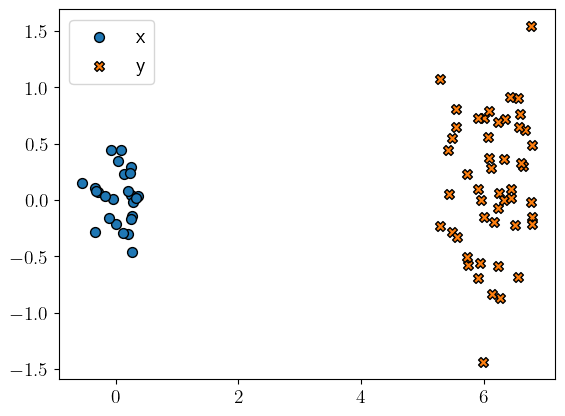

In [6]:
plt.scatter(x[:, 0], x[:, 1], edgecolors="k", marker="o", label="x", s=50)
plt.scatter(y[:, 0], y[:, 1], edgecolors="k", marker="X", label="y", s=50)
plt.legend(fontsize=15)
plt.show()

In [7]:
def gradient_flow(
        x: jnp.ndarray,
        y: jnp.ndarray,
        cost_fn: callable,
        num_iter: int = 500,
        lr: float = 0.2,
        dump_every: int = 50,
        epsilon: float = None,
):
    """Compute a gradient flow."""

    ots = []

    # Apply jax.value_and_grad operator and jit that function.
    cost_fn_vg = jax.jit(jax.value_and_grad(cost_fn, has_aux=True))

    # Perform gradient descent on `x`.
    for i in range(0, num_iter + 1):
        # Define the geometry, then compute the OT cost and its gradient.
        geom = pointcloud.PointCloud(x, y, epsilon=epsilon)
        (cost, ot), geom_g = cost_fn_vg(geom)
        assert ot.converged

        x = x - geom_g.x * lr  # Perform a gradient descent step.
        if i % dump_every == 0:
            ots.append(ot)  # Save the current state of the optimization.

    return ots

In [8]:
def display_animation(ots, plot_class=plot.Plot):
    """Display an animation of the gradient flow."""
    plott = plot_class(show_lines=False)
    anim = plott.animate(ots, frame_rate=4)
    html = display.HTML(anim.to_jshtml())
    display.display(html)
    plt.close()

In [9]:
def reg_ot_cost(geom):
    """Return the OT cost and OT output given a geometry"""
    ot = sinkhorn.Sinkhorn()(linear_problem.LinearProblem(geom))
    return ot.reg_ot_cost, ot

In [10]:
ots = gradient_flow(x, y, reg_ot_cost)
display_animation(ots)

In [11]:
# Compute and display the gradient flow for a larger value of epsilon.
ots = gradient_flow(x, y, reg_ot_cost, epsilon=1.0)
display_animation(ots)

In [12]:
def sink_div(geom):
    """Return the Sinkhorn divergence cost and OT output given a geometry.
    Since y is fixed, we can use static_b=True to avoid computing
    the OT(b, b) term."""

    ot = sinkhorn_divergence.sinkhorn_divergence(
        geom,
        x=geom.x,
        y=geom.y,
        static_b=True,
    )
    return ot.divergence, ot

In [13]:
class CustomPlot(plot.Plot):
    def _scatter(self, ot):
        x, y = ot.geoms[0].x, ot.geoms[0].y
        a, b = ot.a, ot.b
        scales_x = a * self._scale * a.shape[0]
        scales_y = b * self._scale * b.shape[0]
        return x, y, scales_x, scales_y

In [14]:
ots = gradient_flow(x, y, sink_div, epsilon=1.0)
display_animation(ots, plot_class=CustomPlot)